## Introduction

In [2]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                            GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

In [3]:
from pathlib import Path
data_dir = Path('./datasets/Titanic_dataset')
train = pd.read_csv(data_dir / 'train.csv')
test = pd.read_csv(data_dir / 'test.csv')

PassengerId = test['PassengerId']
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, 
                                             age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    title_mapping = {'Mr': 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16)&(dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32)&(dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48)&(dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1


In [6]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Survived     891 non-null    int64
 1   Pclass       891 non-null    int64
 2   Sex          891 non-null    int32
 3   Age          891 non-null    int32
 4   Parch        891 non-null    int64
 5   Fare         891 non-null    int32
 6   Embarked     891 non-null    int32
 7   Name_length  891 non-null    int64
 8   Has_Cabin    891 non-null    int64
 9   FamilySize   891 non-null    int64
 10  IsAlone      891 non-null    int64
 11  Title        891 non-null    int64
dtypes: int32(4), int64(8)
memory usage: 69.7 KB


## visualization

### Correlation Heatmap

<AxesSubplot:title={'center':'Person Correlation of Features'}>

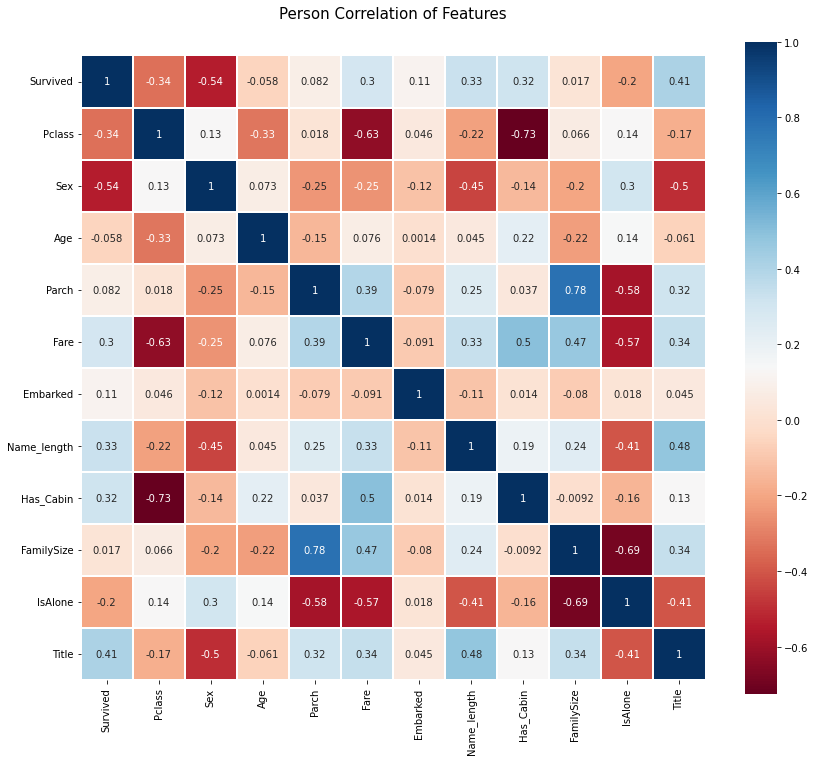

In [8]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Person Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### pairplots

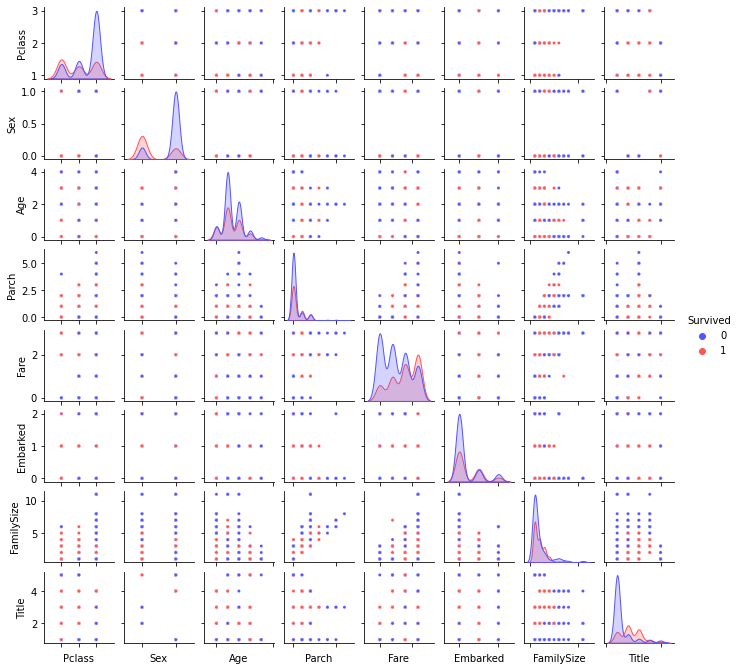

In [9]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch',
                        u'Fare', u'Embarked', u'FamilySize', u'Title']], 
                hue='Survived', palette='seismic', size=1.2, diag_kind='kde',
                diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

### Helpers via Python Classes

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(NFOLDS)
kf.get_n_splits(train)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
    
    def predict(self, X):
        return self.clf.predict(X)
    
    def fit(self, X, y):
        return self.clf.fit(X, y)
    
    def feature_importances(self, X, y):
        return self.clf.fit(X, y).feature_importances_

### Out-of-Fold Predictions

In [11]:
def get_oof(clf, X_train, y_train, X_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_te = X_train[test_index]
        
        clf.train(X_tr, y_tr)
        
        oof_train[test_index] = clf.predict(X_te)
        oof_test_skf[i, :] = clf.predict(X_test)
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models

In [12]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2, 
    'verbose': 0
}

svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

In [13]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [14]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
X_train = train.values
X_test = test.values

In [15]:
et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_test)
rf_oof_train, rf_oof_test = get_oof(rf, X_train, y_train, X_test)
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test)
gb_oof_train, gb_oof_test = get_oof(gb, X_train, y_train, X_test)
svc_oof_train, svc_oof_test = get_oof(svc, X_train, y_train, X_test)

### Feature importances

In [16]:
rf_features = rf.feature_importances(X_train, y_train)
et_features = et.feature_importances(X_train, y_train)
ada_features = ada.feature_importances(X_train, y_train)
gb_features = gb.feature_importances(X_train, y_train)

In [17]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({
    'features': cols, 
    'Random Forest feature importances': rf_features,
    'Extra Trees feature importances': et_features,
    'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
})

In [18]:
feature_dataframe.head()

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.125636,0.121552,0.028,0.086960
1,Sex,0.198077,0.380087,0.012,0.013849
2,Age,0.031088,0.027894,0.016,0.053688
3,Parch,0.021780,0.016042,0.068,0.014603
4,Fare,0.071705,0.056094,0.038,0.050417


In [20]:
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values, 
    x = feature_dataframe['features'].values, 
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25, 
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ), 
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values, 
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Extra Trees Feature Importance', 
    hovermode = 'closest', 
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')


trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values, 
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'AdaBoost Feature Importance', 
    hovermode = 'closest', 
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')


trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values, 
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Gradient Boosting Feature Importance', 
    hovermode = 'closest', 
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [21]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.125636,0.121552,0.028,0.086960,0.090537
1,Sex,0.198077,0.380087,0.012,0.013849,0.151003
2,Age,0.031088,0.027894,0.016,0.053688,0.032168


In [22]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x = x,
            y = y,
            width = 0.5,
            marker = dict(
                color = feature_dataframe['mean'].values,
                colorscale = 'Portland',
                showscale = True,
                reversescale = False
            ),
            opacity = 0.6
        )]

layout = go.Layout(
    autosize = True,
    title = 'Barplots of Mean Feature Importance', 
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output

In [23]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(), 
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel()
})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [24]:
data = [
    go.Heatmap(
        z = base_predictions_train.astype(float).corr().values, 
        x = base_predictions_train.columns.values,
        y = base_predictions_train.columns.values,
        colorscale = 'Viridis',
        showscale = True,
        reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [25]:
X_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, 
                         gb_oof_train, svc_oof_train), axis=1)
X_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, 
                        gb_oof_test, svc_oof_test), axis=1)

### Second level learning model via XGBoost

In [26]:
gbm = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1
).fit(X_train, y_train)
predictions = gbm.predict(X_test)

[10:37:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [27]:
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 
                                   'Survived': predictions})
StackingSubmission.to_csv("./predict/Titanic4_predict.csv", index=False)